In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

from crowd_tracker_lidar3d.loader import load_data_to_dataframe
from crowd_tracker_lidar3d.plot_tools import plot_pointcloud3d, draw_point_cloud, show_projections
from crowd_tracker_lidar3d.preprocessing import rotate_pcl, df_apply_rot, return_ground_points, remove_ground_points, standardize_data
import matplotlib.pyplot as plt 

In [3]:
walking_dist = 3 

In [4]:
filename = '{}m_1person_labeled-front_lidar-velodyne_points'.format(str(walking_dist))

In [5]:
bag_dir = os.path.dirname(os.path.abspath(''))
bag_dir = os.path.join(bag_dir, "data")
data = load_data_to_dataframe(filename, bag_dir)

In [6]:
# Helper Function to save plots 
def save_fig(fig, filename, extension='.pdf'):
    save_dir = os.getcwd()
    save_dir = os.path.join(save_dir, "../plots/") + str(filename) + extension
    fig.savefig(save_dir, bbox_inches='tight')  

### Data Overview

In [7]:
data.shape

(5703670, 6)

In [8]:
data.head()

,rosbagTimestamp,x,y,z,intensity,time
0,1585676291247622519,-1.030228,-0.526967,0.310065,1.0,-0.099263
1,1585676291247622519,-1.063074,-0.539095,0.319383,1.0,-0.099208
2,1585676291247622519,-1.101393,-0.548894,0.329735,1.0,-0.099097
3,1585676291247622519,-1.125818,-0.556170,0.336465,1.0,-0.099042
4,1585676291247622519,-1.178068,-0.576874,0.351476,4.0,-0.098986


In [9]:
# investigate value ranges
x_max, x_min = np.max(data.x), np.min(data.x)
y_max, y_min = np.max(data.y), np.min(data.y)
z_max, z_min = np.max(data.z), np.min(data.z)
intensity_max, intensity_min = np.max(data.intensity), np.min(data.intensity)

print('x_max: {:.3f}, x_min: {:.3f}'.format(x_max, x_min))
print('y_max: {:.3f} y_min: {:.3f}'.format(y_min, y_max))
print('z_max: {:.3f}, z_min: {:.3f}'.format(z_max, z_min))
print('intensity_max: {:.3f}, intensity_min: {:.3f}'.format(intensity_max, intensity_min))
print('\nNumber of points: {}'.format(data.shape[0]))

x_max: 24.621, x_min: -5.045
y_max: -6.891 y_min: 4.699
z_max: 6.225, z_min: -0.526
intensity_max: 148.000, intensity_min: 0.000

Number of points: 5703670


In [10]:
# Number of unique timestamps
timesteps = data.rosbagTimestamp.unique()
len(timesteps)

282

In [13]:
len(data.x.between(2.5,3.5))

5703670

In [13]:
# Analyze pointclouds from first and very last timestamp
start = data[data.rosbagTimestamp == timesteps[0]]
end = data[data.rosbagTimestamp == timesteps[-1]]

In [14]:
print(len(start))
print(len(end))

20079
20346


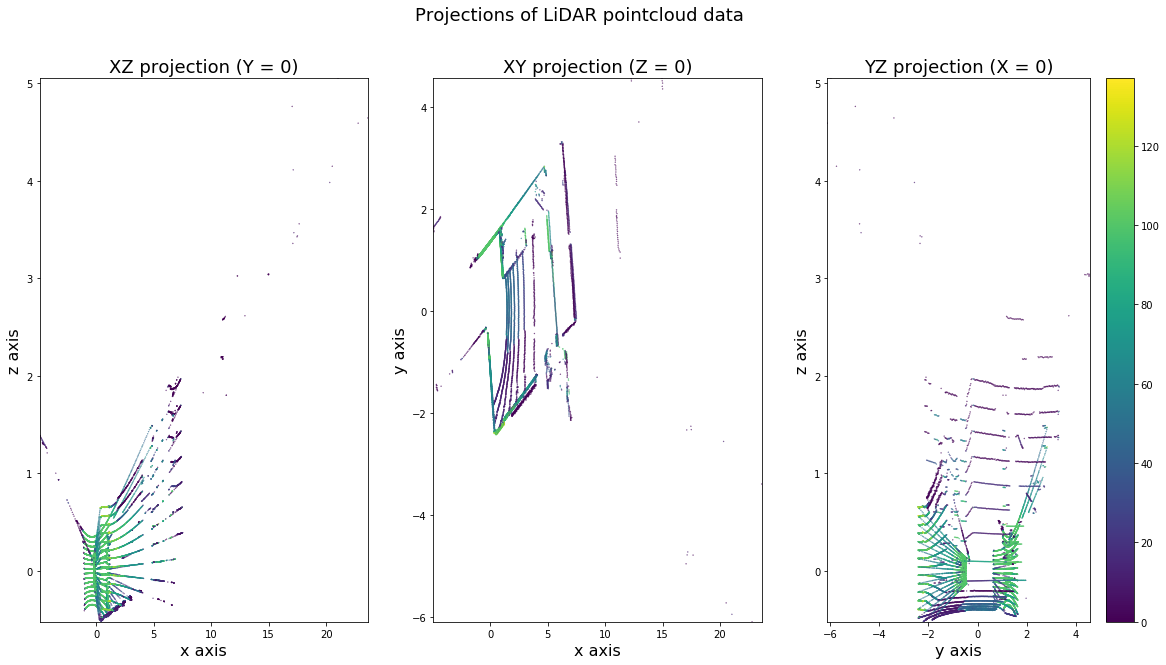

In [15]:
show_projections(start, ['x', 'y', 'z', 'intensity']) #, savefig=True, filename='1m_labeled_raw_timestep0')

### Transform data set and filter floor points

In [16]:
# Set threshold in z-value 
thresh = -0.38

In [17]:
# Rotate points to compensate for LiDAR tilt angle 
start_transformed = df_apply_rot(start)

In [18]:
# Mean difference of z values before and after transformation
np.mean(start_transformed.z - start.z)

-0.11330023590720592

Total number of data points: 20079
Number of data points after filtering for floor points: 15816


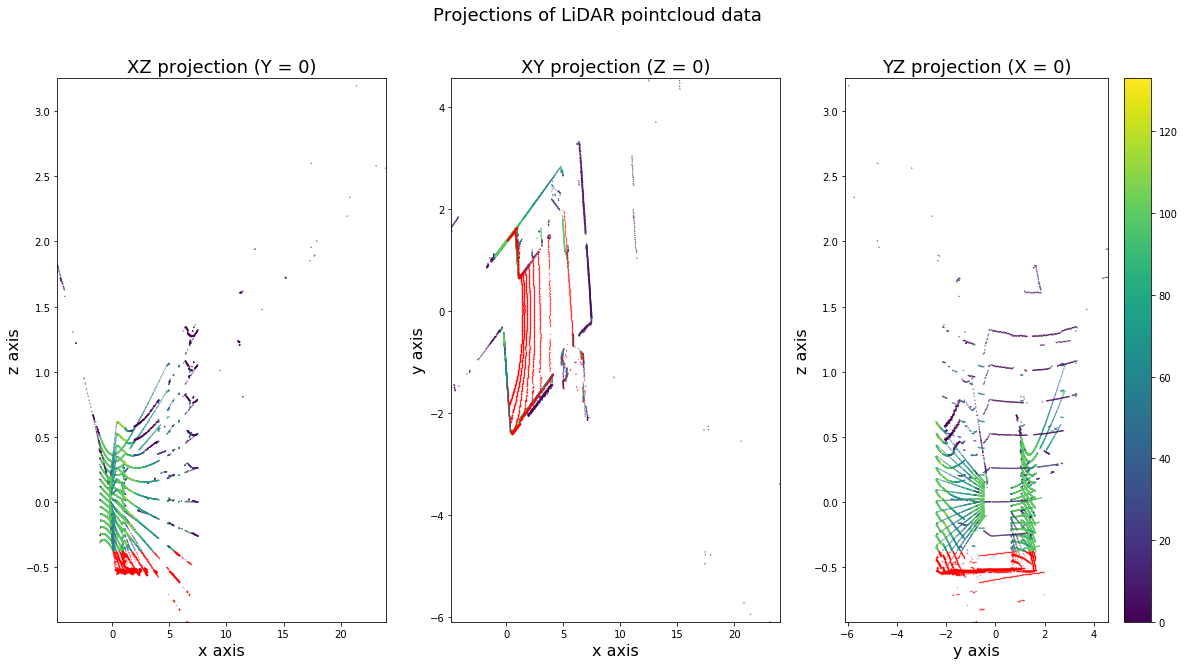

Filtered floor points


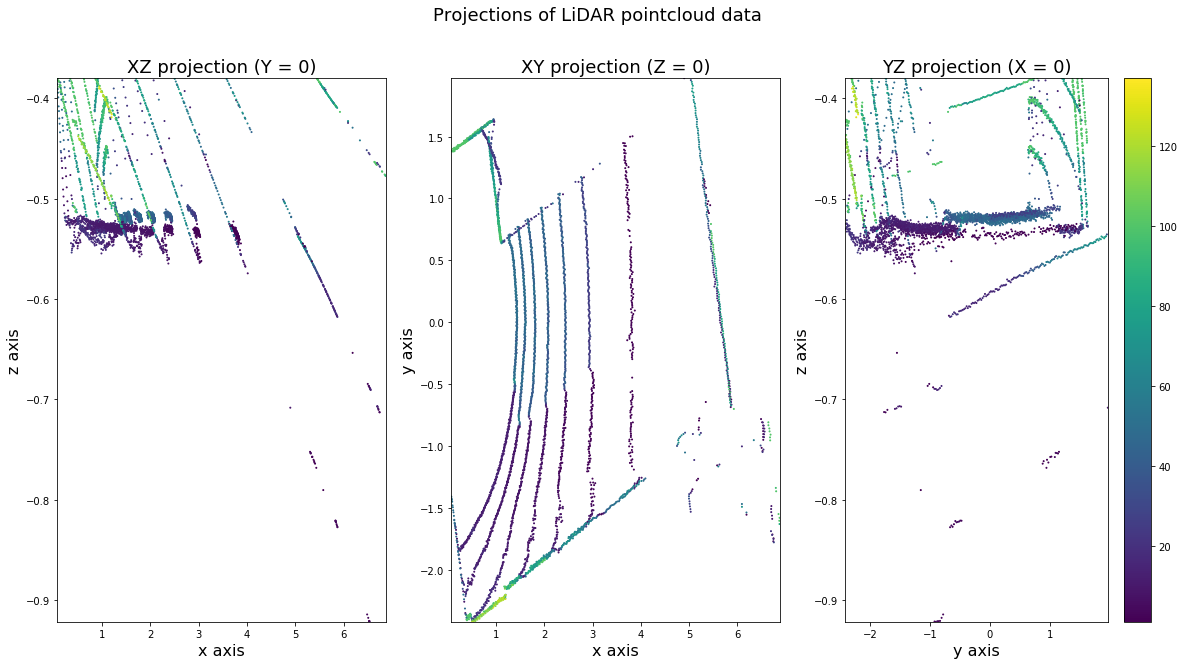

Points selected for segmentation after filtering out floor points


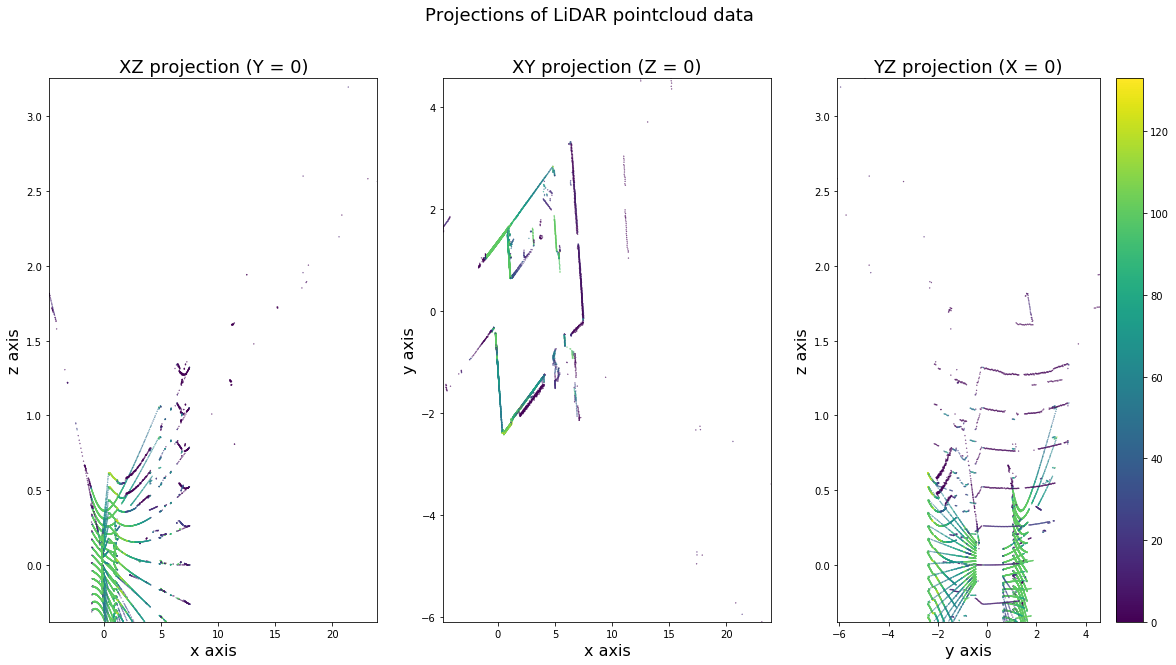

In [19]:
%matplotlib inline
ground_vals_after_rot = return_ground_points(start_transformed, thresh)
start_filtered = remove_ground_points(start_transformed, thresh)
print('Total number of data points: {}\nNumber of data points after filtering for floor points: {}'.format(start_transformed.shape[0], start_filtered.shape[0]))
show_projections(start_filtered, ['x', 'y', 'z', 'intensity'], point_eliminations=ground_vals_after_rot) #, savefig=True, filename='3m_labeled_point_eliminations_rotated_start')
print('Filtered floor points')
show_projections(ground_vals_after_rot, ['x', 'y', 'z', 'intensity']) #, savefig=True, filename='3m_labeled_floorpoints_rotated_start')
print('Points selected for segmentation after filtering out floor points')
show_projections(start_filtered, ['x', 'y', 'z', 'intensity']) #, savefig=True, filename='3m_labeled_data_wo_floor_rotated_start')

## Extract Ground Truth 

### A) By knowing distance at which dataset was measured

In [19]:
# Preprocessing: transform data 
data_transformed = df_apply_rot(data)

In [20]:
np.mean(data_transformed.x - data.x)

0.0024596339959730056

In [21]:
for i, t in enumerate(timesteps):
#     df = data[(data.rosbagTimestamp== t) & (data.x.between(2.5, 3.5))]
    df = data[data.rosbagTimestamp== t]
    ground_truth = df[df.x.between(2.8, 3.5)]
    print('timestep {}: {:.2f} % of points within walking distance, absolute amount: {}'.format(i, 100*float(ground_truth.shape[0])/float(df.shape[0]), ground_truth.shape[0]))

timestep 0: 3.84 % of points within walking distance, absolute amount: 772
timestep 1: 3.86 % of points within walking distance, absolute amount: 775
timestep 2: 3.86 % of points within walking distance, absolute amount: 776
timestep 3: 3.91 % of points within walking distance, absolute amount: 786
timestep 4: 3.89 % of points within walking distance, absolute amount: 781
timestep 5: 3.88 % of points within walking distance, absolute amount: 779
timestep 6: 3.86 % of points within walking distance, absolute amount: 774
timestep 7: 3.88 % of points within walking distance, absolute amount: 779
timestep 8: 3.88 % of points within walking distance, absolute amount: 780
timestep 9: 3.88 % of points within walking distance, absolute amount: 779
timestep 10: 3.86 % of points within walking distance, absolute amount: 774
timestep 11: 3.87 % of points within walking distance, absolute amount: 776
timestep 12: 3.86 % of points within walking distance, absolute amount: 774
timestep 13: 3.87 % of

timestep 130: 5.20 % of points within walking distance, absolute amount: 1043
timestep 131: 5.24 % of points within walking distance, absolute amount: 1051
timestep 132: 5.28 % of points within walking distance, absolute amount: 1061
timestep 133: 5.17 % of points within walking distance, absolute amount: 1036
timestep 134: 5.06 % of points within walking distance, absolute amount: 1015
timestep 135: 4.96 % of points within walking distance, absolute amount: 996
timestep 136: 4.92 % of points within walking distance, absolute amount: 987
timestep 137: 5.15 % of points within walking distance, absolute amount: 1033
timestep 138: 5.22 % of points within walking distance, absolute amount: 1048
timestep 139: 5.17 % of points within walking distance, absolute amount: 1040
timestep 140: 5.09 % of points within walking distance, absolute amount: 1033
timestep 141: 4.98 % of points within walking distance, absolute amount: 1011
timestep 142: 4.88 % of points within walking distance, absolute a

timestep 257: 3.83 % of points within walking distance, absolute amount: 779
timestep 258: 3.83 % of points within walking distance, absolute amount: 778
timestep 259: 3.81 % of points within walking distance, absolute amount: 775
timestep 260: 3.79 % of points within walking distance, absolute amount: 770
timestep 261: 3.83 % of points within walking distance, absolute amount: 779
timestep 262: 3.81 % of points within walking distance, absolute amount: 774
timestep 263: 3.82 % of points within walking distance, absolute amount: 778
timestep 264: 3.79 % of points within walking distance, absolute amount: 772
timestep 265: 3.82 % of points within walking distance, absolute amount: 777
timestep 266: 3.81 % of points within walking distance, absolute amount: 774
timestep 267: 3.81 % of points within walking distance, absolute amount: 774
timestep 268: 3.80 % of points within walking distance, absolute amount: 774
timestep 269: 3.84 % of points within walking distance, absolute amount: 780

564
350


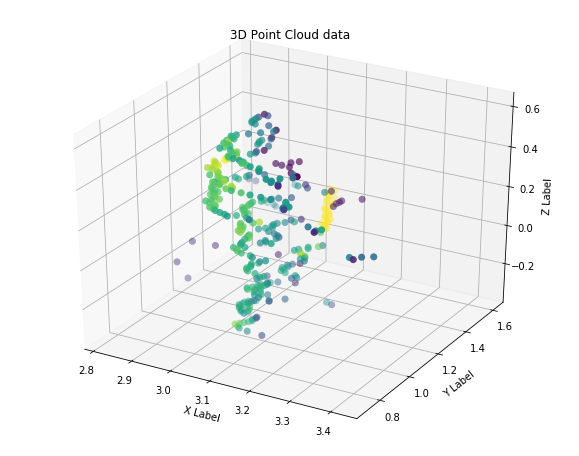

(0.7140030860900879, 1.6117109060287476)


In [22]:
test = data[data.rosbagTimestamp == timesteps[150]].reset_index()
test_trans = df_apply_rot(test)
test_trans = test_trans[(test_trans.x.between(2.8, 3.5)) & (test_trans.y.between(-1, 2))]
print(len(test_trans))
test_trans = remove_ground_points(test_trans, -0.38)
print(len(test_trans))
plot_pointcloud3d(test_trans)
print(np.min(test_trans.y), np.max(test_trans.y))

### B) Via DROW Detector 

In [13]:
det_file = '{}m_1person_labeled-drow_detected_persons'.format(walking_dist)
detections = load_data_to_dataframe(det_file, bag_dir)

In [14]:
detections.head()

,rosbagTimestamp,detection_id,confidence,det_x,det_y,det_z,height
0,1585676291995056759,156,0.596226,4.765054,-0.918280,1.0,1.85
1,1585676293500363159,157,0.453330,3.278968,-0.820169,1.0,1.85
2,1585676293606525671,158,0.525579,3.250573,-0.835925,1.0,1.85
3,1585676293834309911,159,0.457082,3.189745,-0.841848,1.0,1.85
4,1585676293932619159,160,0.641975,3.132249,-0.803441,1.0,1.85


In [15]:
detections.shape

(119, 7)

In [16]:
print(len(detections.rosbagTimestamp.unique()))
print(len(data.rosbagTimestamp.unique()))

119
282


In [17]:
# Match closest available detection to each timestamp in data 
df_with_detections = data.copy()
df_with_detections = pd.merge_asof(data, detections, on='rosbagTimestamp', direction='forward')

In [18]:
data.shape

(5703670, 6)

In [19]:
df_with_detections.shape

(5703670, 12)

In [20]:
df_with_detections.head()

,rosbagTimestamp,x,y,z,intensity,time,detection_id,confidence,det_x,det_y,det_z,height
0,1585676291247622519,-1.030228,-0.526967,0.310065,1.0,-0.099263,156.0,0.596226,4.765054,-0.91828,1.0,1.85
1,1585676291247622519,-1.063074,-0.539095,0.319383,1.0,-0.099208,156.0,0.596226,4.765054,-0.91828,1.0,1.85
2,1585676291247622519,-1.101393,-0.548894,0.329735,1.0,-0.099097,156.0,0.596226,4.765054,-0.91828,1.0,1.85
3,1585676291247622519,-1.125818,-0.556170,0.336465,1.0,-0.099042,156.0,0.596226,4.765054,-0.91828,1.0,1.85
4,1585676291247622519,-1.178068,-0.576874,0.351476,4.0,-0.098986,156.0,0.596226,4.765054,-0.91828,1.0,1.85


In [23]:
det_timesteps = df_with_detections.rosbagTimestamp.unique()
print(len(det_timesteps))

282


In [32]:
# Activate interactive plotting mode to be able to zoom in 
%matplotlib notebook


#### 3D Plot 

49


<IPython.core.display.Javascript object>


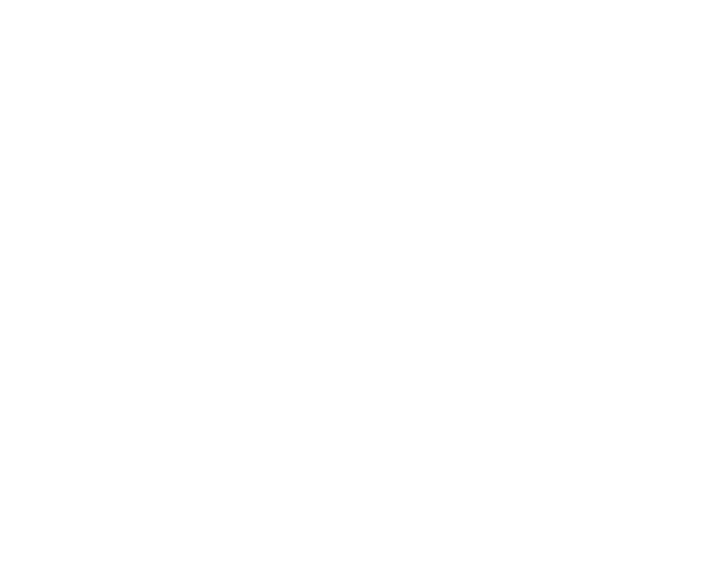

52


<IPython.core.display.Javascript object>


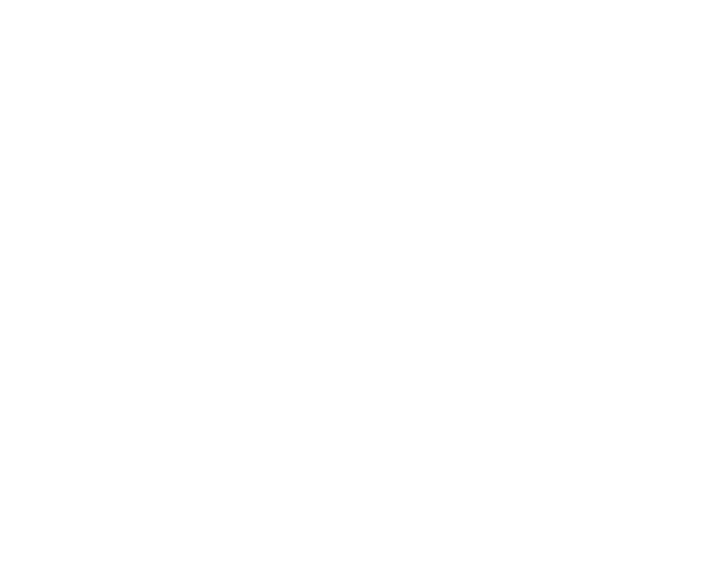

50


<IPython.core.display.Javascript object>


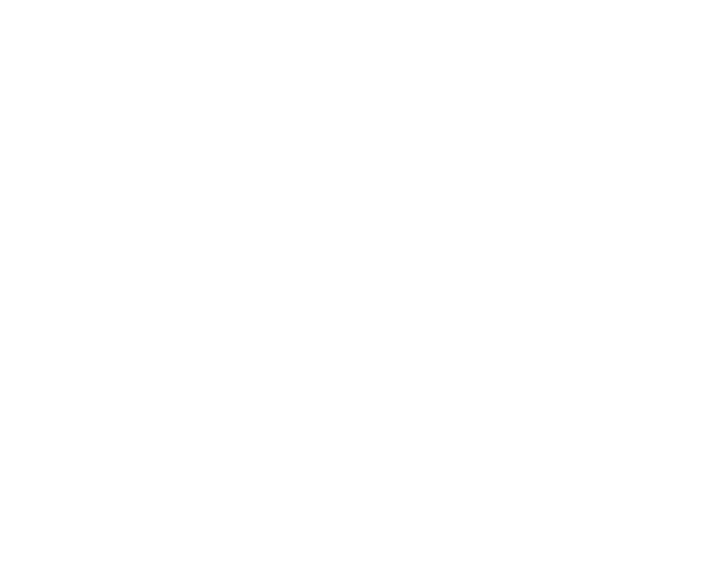

52


<IPython.core.display.Javascript object>


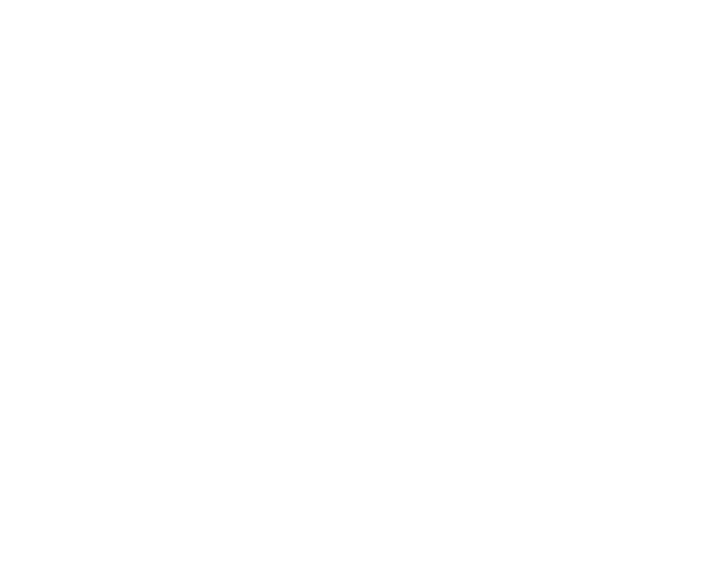

<IPython.core.display.Javascript object>


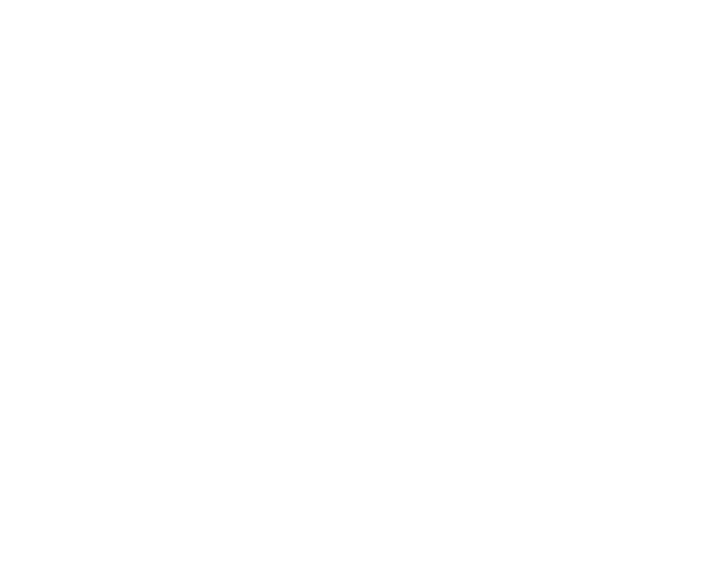

<IPython.core.display.Javascript object>


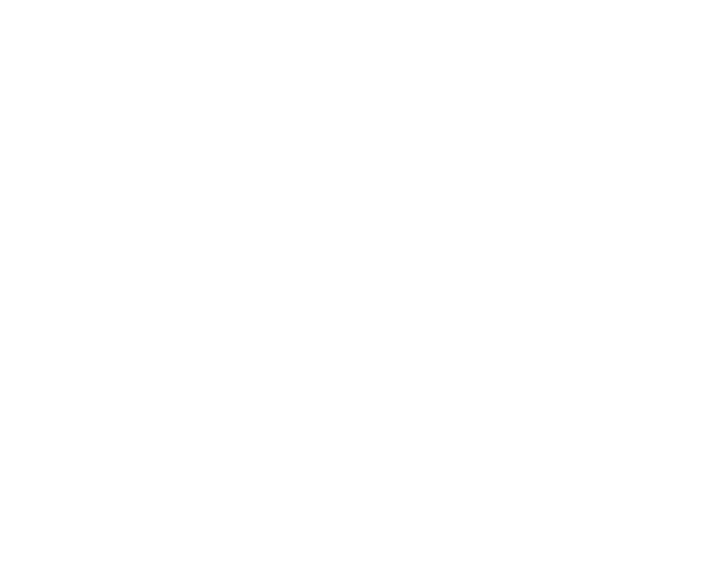

<IPython.core.display.Javascript object>


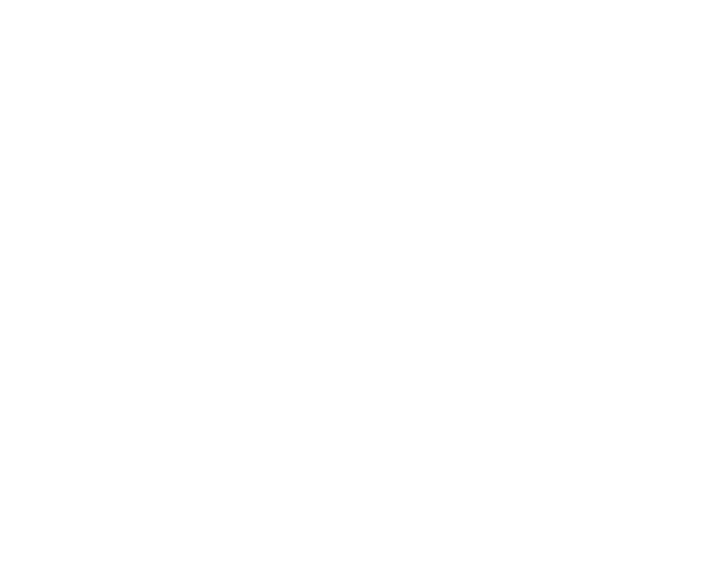

<IPython.core.display.Javascript object>


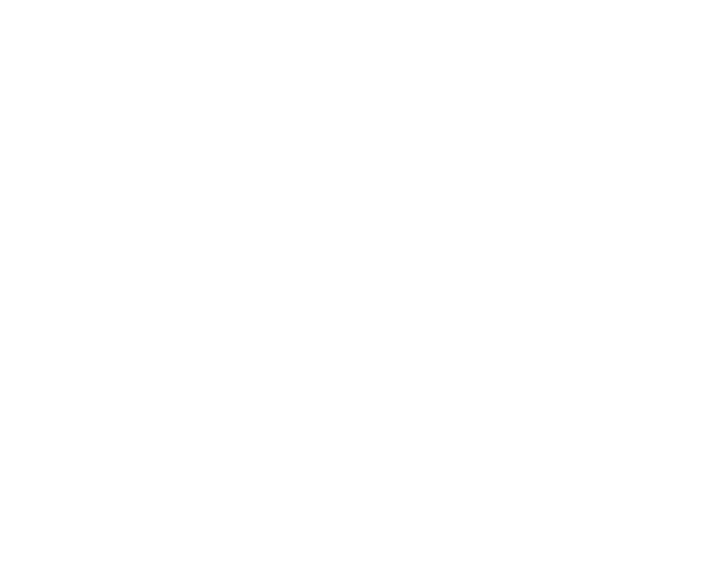

In [33]:
for i,t in enumerate(det_timesteps):
    x = df_with_detections[df_with_detections.rosbagTimestamp == det_timesteps[i]].reset_index()
    x_trans = df_apply_rot(x)
    x_trans = x_trans[(x_trans.x.between(2.8, 3.5)) & (x_trans.y.between(-1, 2))]
    x_trans = remove_ground_points(x_trans, -0.38)
    no_points = x_trans.shape[0]
    point_size = 10**(3- int(np.log10(no_points))) # Adjust point size based on point cloud size
    print(len(x_trans))
    
    
    plt.ion()
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_trans['x'], x_trans['y'], x_trans['z'], c=x_trans['intensity'], s=point_size*4, edgecolor='', marker='o')
    ax.scatter(x.det_x, x.det_y, x.det_z, c= 'r', s=point_size*4, edgecolor='', marker='.')
    
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.title('3D Point Cloud data')
    plt.show()
    if i == 3: 
        break

#### 2D Plots

In [34]:
subsample = det_timesteps[::45]

Timestamp: 1585676291247622519
15816


<IPython.core.display.Javascript object>


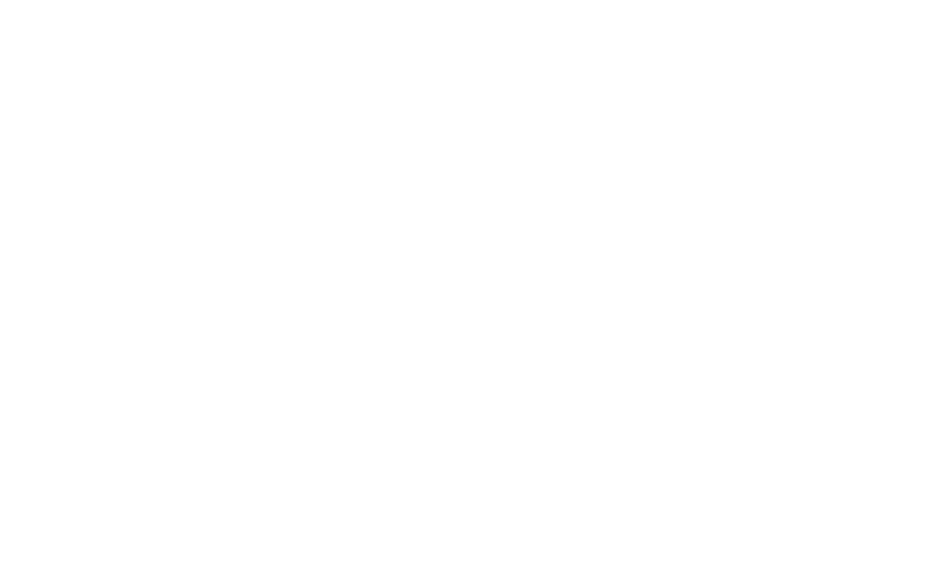

Timestamp: 1585676295785682951
16001


<IPython.core.display.Javascript object>


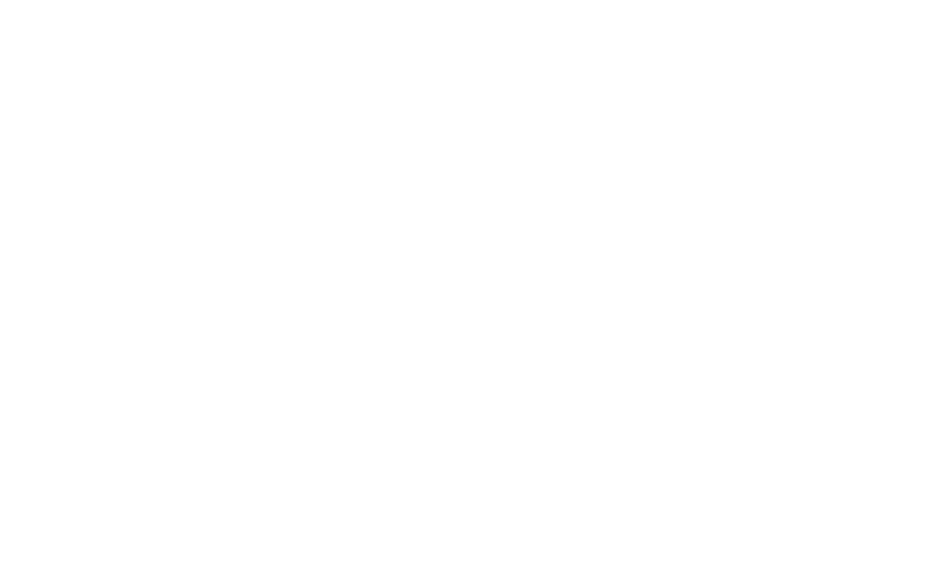

Timestamp: 1585676300326047063
16012


<IPython.core.display.Javascript object>


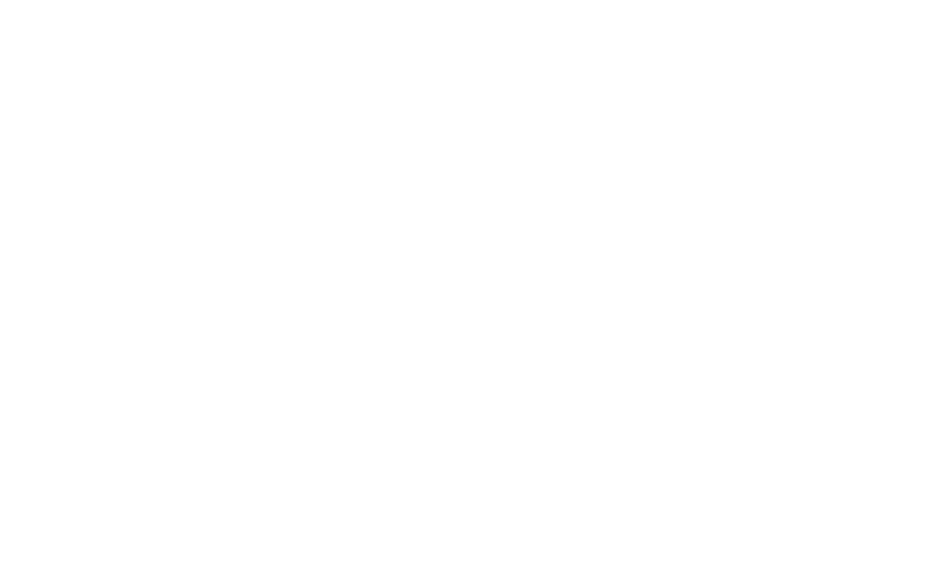

Timestamp: 1585676304866453015
15849


<IPython.core.display.Javascript object>


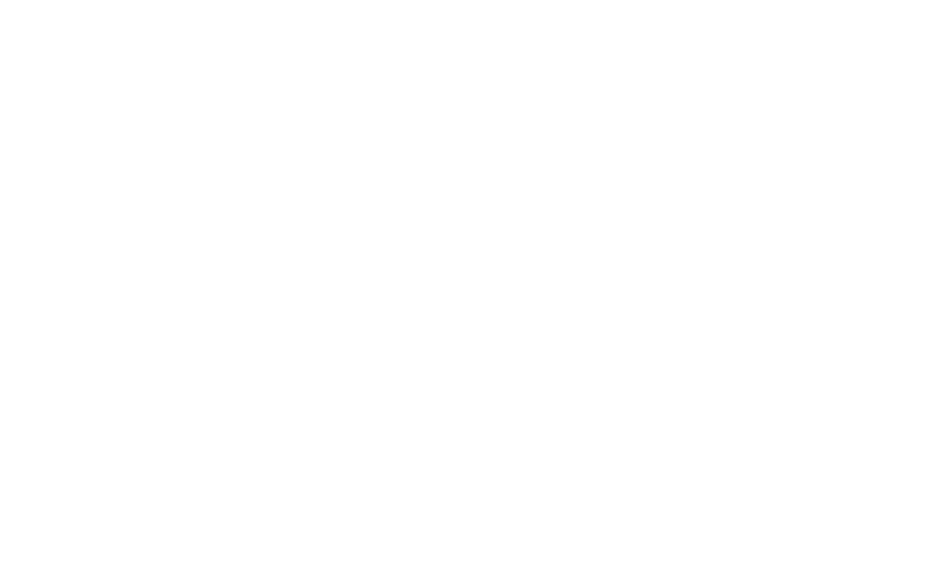

Timestamp: 1585676309400793607
15985


<IPython.core.display.Javascript object>


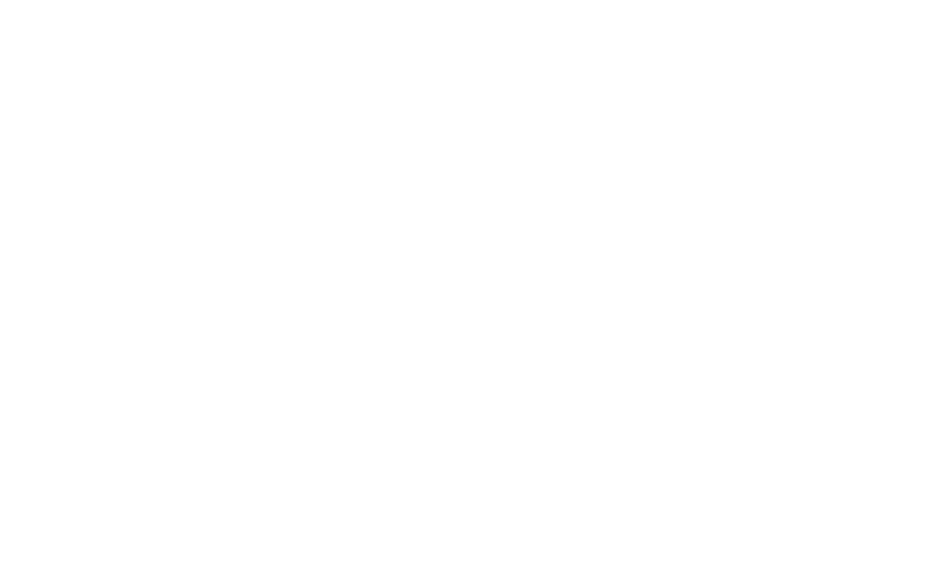

Timestamp: 1585676313937753671
15820


<IPython.core.display.Javascript object>


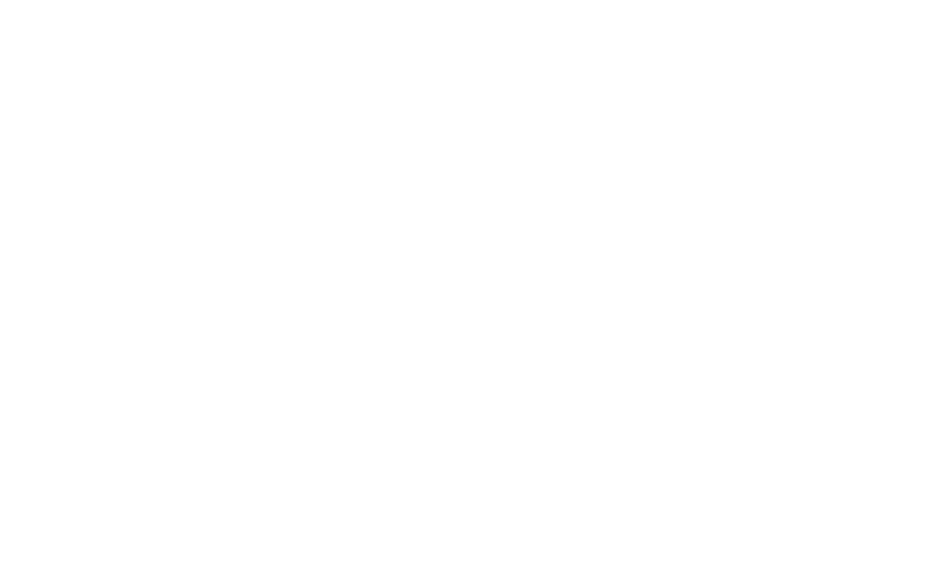

Timestamp: 1585676318477447543
16058


<IPython.core.display.Javascript object>


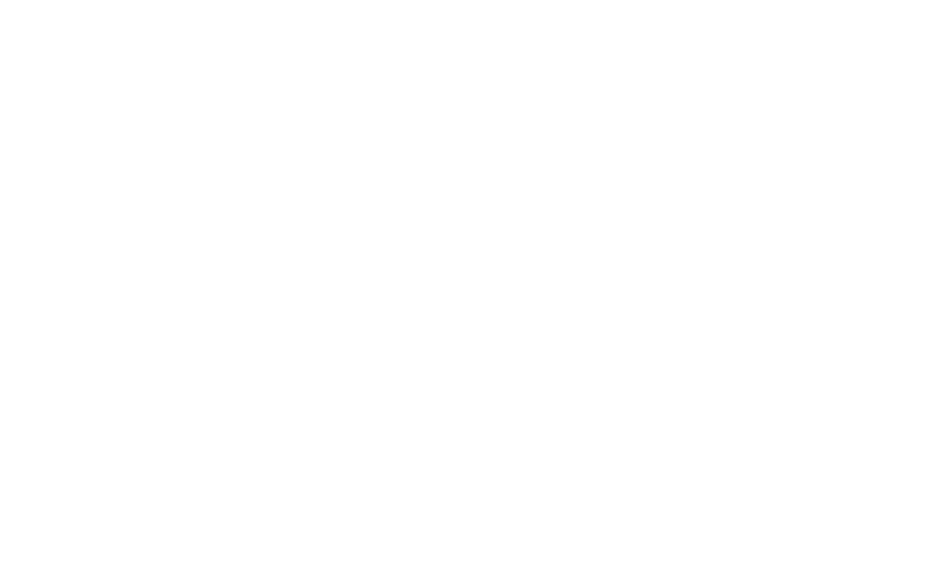

<IPython.core.display.Javascript object>


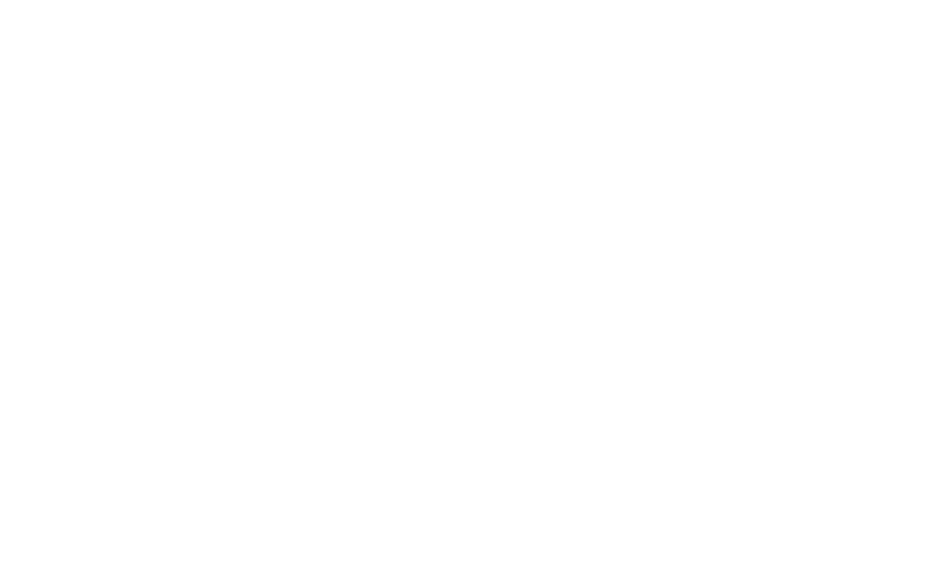

<IPython.core.display.Javascript object>


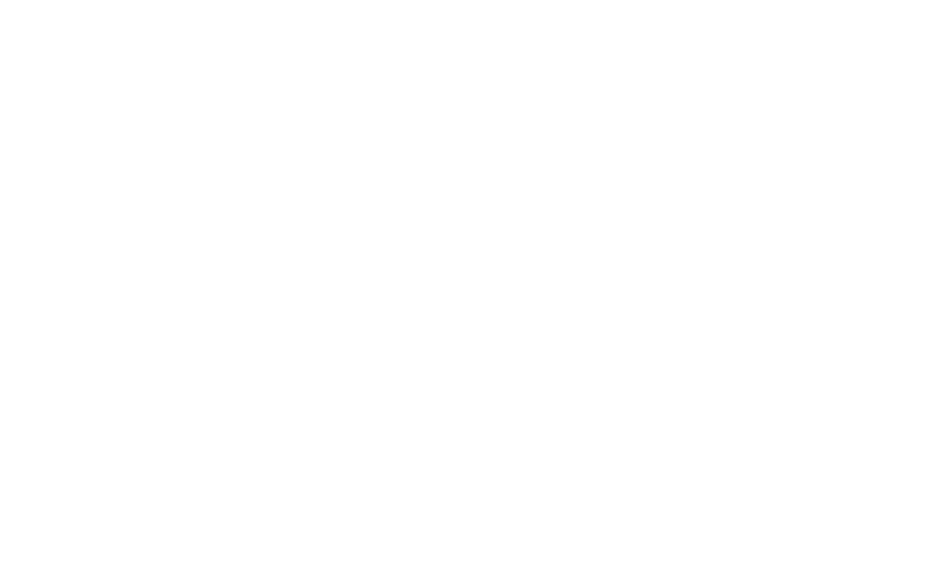

<IPython.core.display.Javascript object>


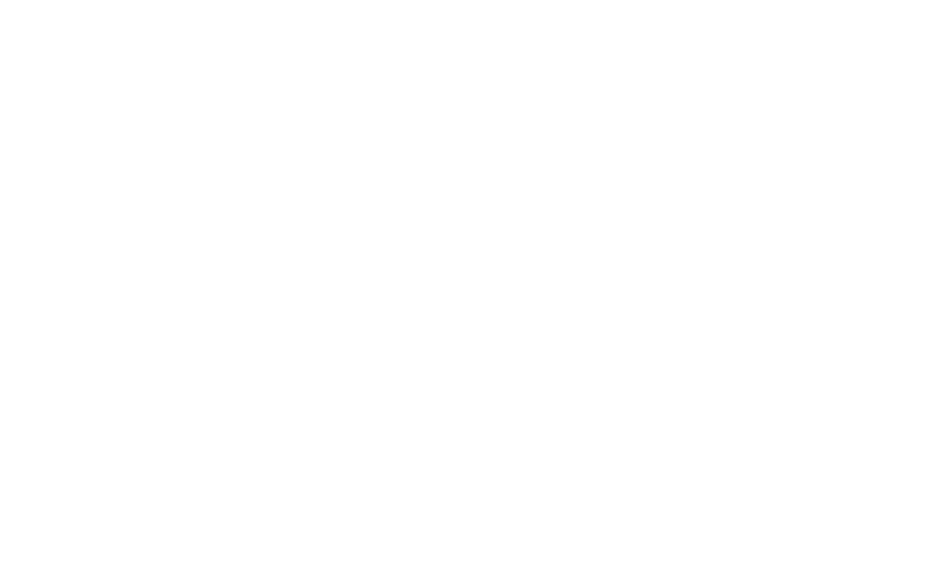

<IPython.core.display.Javascript object>


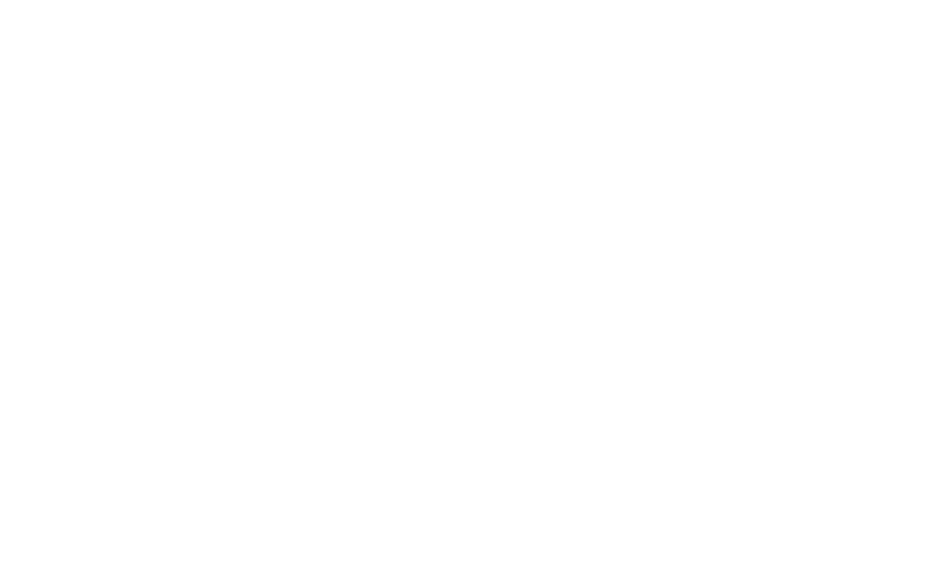

<IPython.core.display.Javascript object>


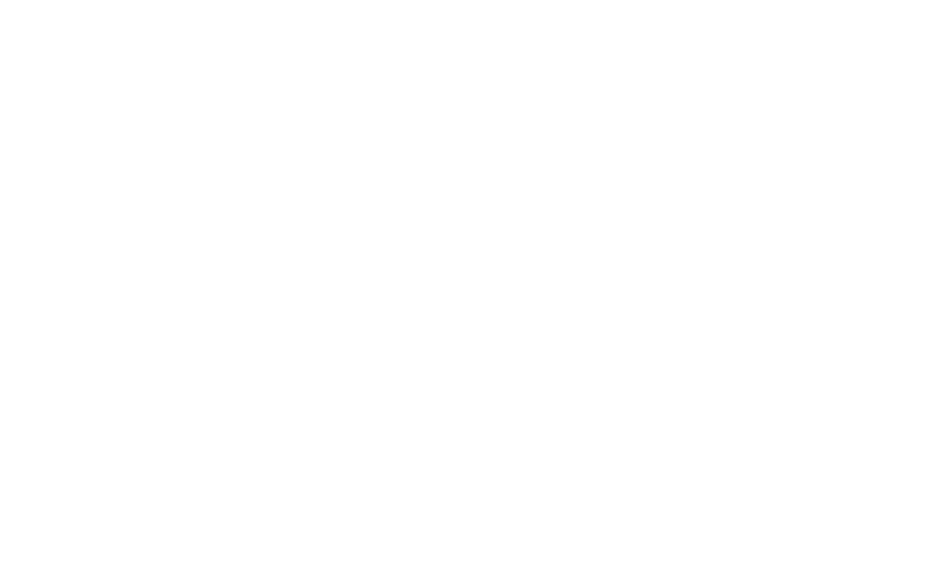

<IPython.core.display.Javascript object>


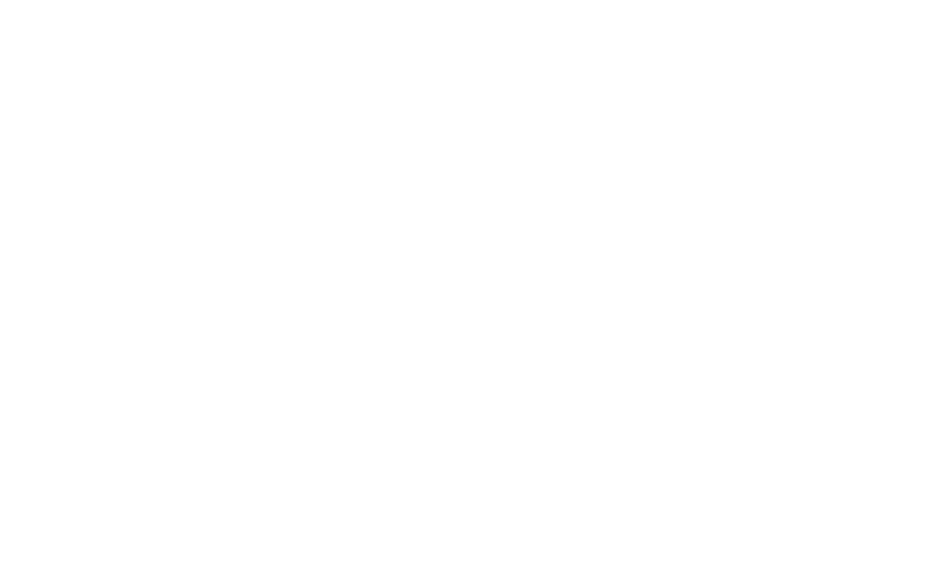

<IPython.core.display.Javascript object>


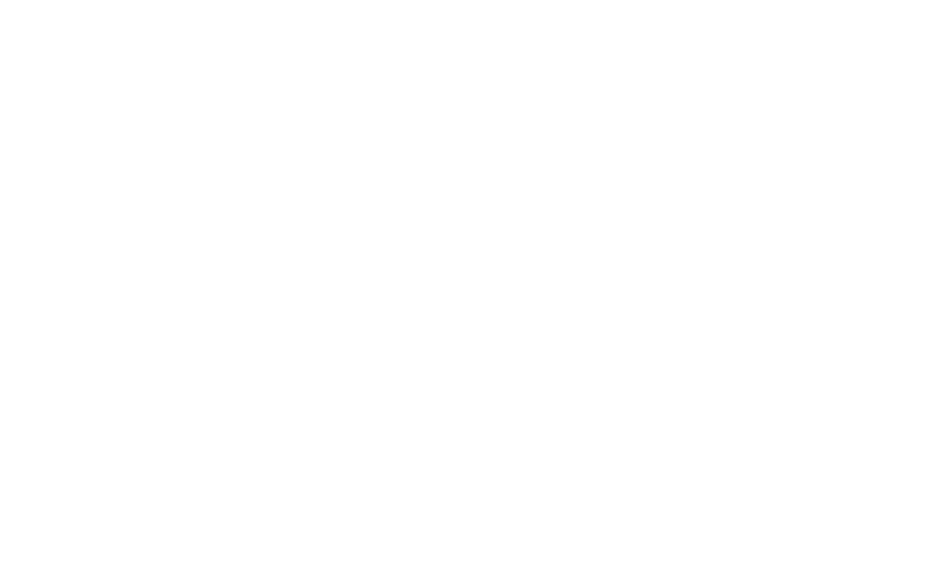

In [35]:
for i,t in enumerate(subsample):
    print('Timestamp: {}'.format(t))
    x = df_with_detections[df_with_detections.rosbagTimestamp == subsample[i]].reset_index()
    x_trans = df_apply_rot(x)
    x_trans = remove_ground_points(x_trans, -0.38)
    print(len(x_trans))
    
    fig = plt.figure(figsize=[13,8])
    ax = fig.add_subplot(111)
    ax.scatter(x_trans['x'], x_trans['y'], c=x_trans['intensity'], s=7, edgecolor='', marker='o')
    ax.scatter(x.det_x, x.det_y, c= 'r', s=30, edgecolor='', marker='x')
    
    
    ax.set_xlabel('X-Dimension', fontsize=18)
    ax.set_ylabel('Y-Dimension', fontsize=18)
    ax.set_xlim([-5,15])
    ax.set_ylim([-4, 5])
    ax.tick_params(labelsize=14)
    fig.colorbar(ax.collections[0], ax=ax)

    
    plt.title('{}m LiDAR data with DROW detections projected on XY-Plane'.format(walking_dist), fontsize=18)
    filename = '{}m_data_detections{}'.format(walking_dist,i)
    save_dir = os.getcwd()
    save_dir = os.path.join(save_dir, "../plots/") + str(filename) + '.pdf'
    
#     plt.savefig(save_dir, bbox_inches='tight', dpi=40)  
    plt.show()
    

## SEGMENTATION - Clustering

### 1) DBSCAN

In [21]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric

In [22]:
timestamp = 1585676313937753671
x = df_with_detections[df_with_detections.rosbagTimestamp == timestamp].reset_index()
x_trans = df_apply_rot(x)
x_trans = remove_ground_points(x_trans, -0.38)
print(x_trans.shape)

(15820, 4)


In [23]:
# Data 
norm_data = standardize_data(x_trans)
cluster_data = norm_data.to_numpy()
print(cluster_data.shape)

(15820, 4)


Finding optimal value for $\epsilon$ as shown in [this source](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc) at the point of maximum curvature in the distances to the clostest n_neighbors.

<IPython.core.display.Javascript object>


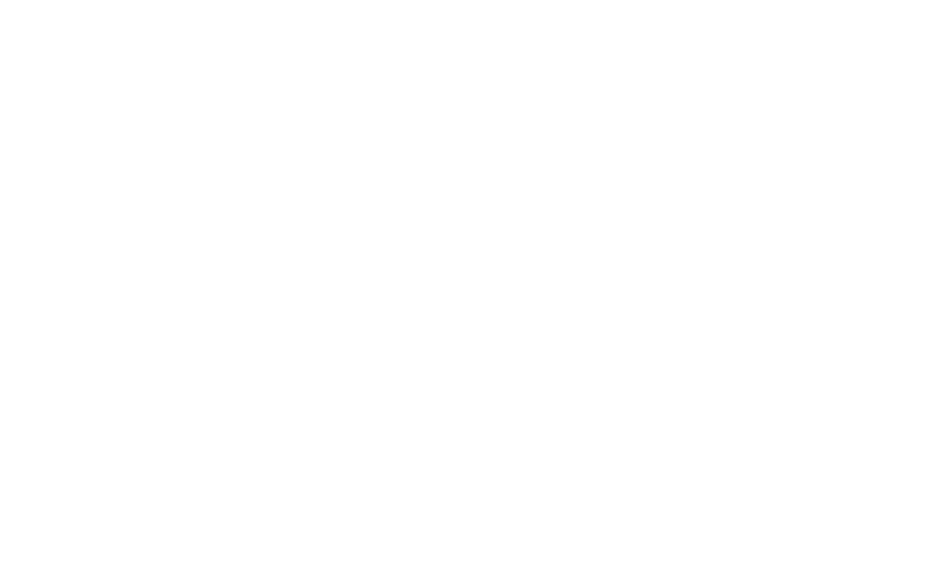

<IPython.core.display.Javascript object>


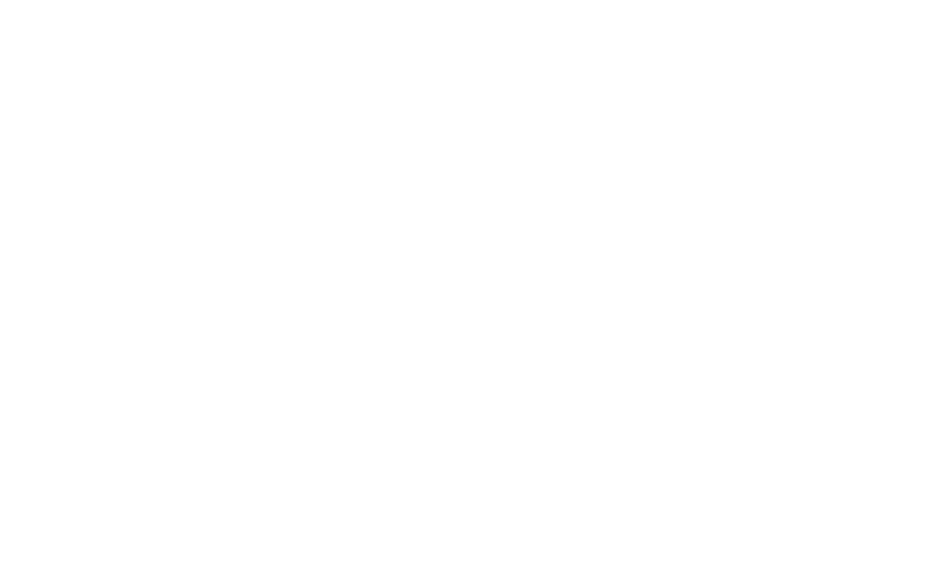

In [39]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cluster_data)
# indices of the nearest points in the population matrix.
distances, indices = nbrs.kneighbors(cluster_data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
fig = plt.figure(figsize=[13,8])
plt.xlabel('Point indices', fontsize=18)
plt.ylabel('Distance to nearest neighbor', fontsize=18)
plt.title('Nearest Neighbors of Points with Euclidian Distance Metric', fontsize=18)
plt.tick_params(labelsize=14)
plt.plot(distances)
save_fig(fig, 'DBSCAN_NNeigh_Eucl')

In [40]:
distances.shape

(15820,)

In [41]:
neigh = NearestNeighbors(n_neighbors=2, 
                         metric='mahalanobis', 
                         metric_params={'V': np.cov(cluster_data, rowvar=False)})
nbrs = neigh.fit(cluster_data)
distances, indices = nbrs.kneighbors(cluster_data)
distances = distances[:,1]

<IPython.core.display.Javascript object>


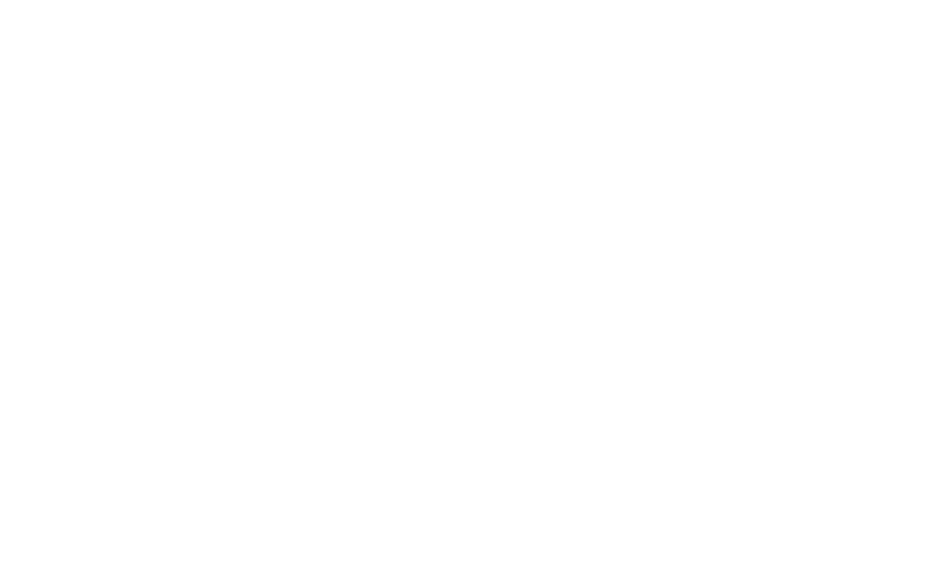

<IPython.core.display.Javascript object>


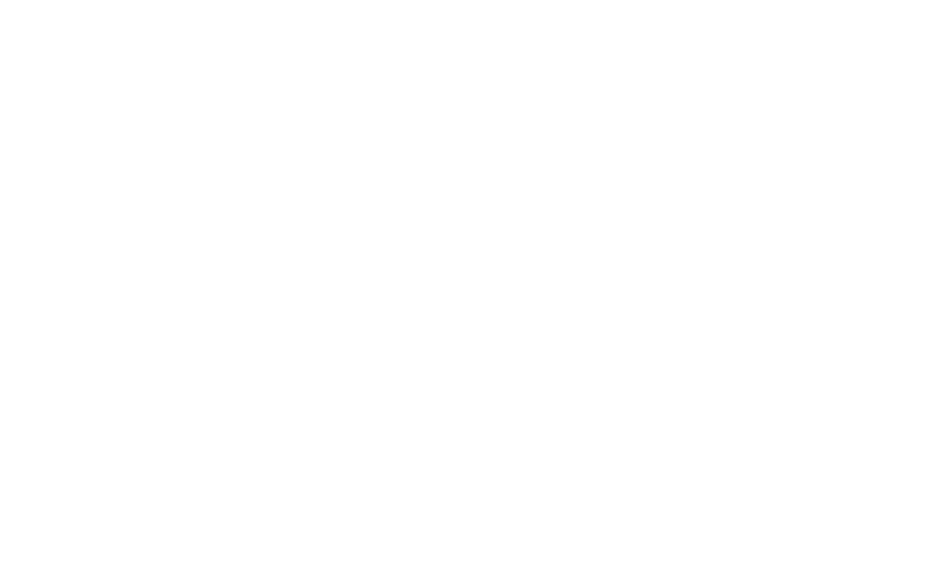

In [42]:
fig = plt.figure(figsize=[13,8])
plt.xlabel('Point indices', fontsize=18)
plt.ylabel('Distance to nearest neighbor', fontsize=18)
plt.title('Nearest Neighbors of Points with Mahalanobis Distance Metric', fontsize=18)
plt.tick_params(labelsize=14)
plt.plot(distances)
save_fig(fig, 'DBSCAN_NNeigh_Mahal')

In [43]:
# evaluate different distance metrics under kd_tree algorithm
from sklearn import neighbors
neighbors.VALID_METRICS['kd_tree']

['chebyshev',
 'euclidean',
 'cityblock',
 'manhattan',
 'infinity',
 'minkowski',
 'p',
 'l2',
 'l1']

In [44]:
# Activate interactive plotting mode to be able to zoom in 
%matplotlib notebook
%matplotlib notebook

In [45]:
def return_cluster_and_noise_points(cluster_model): 
    labels = cluster_model.labels_
    #  Number of clusters in labels, ignoring noise if present
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    return n_clusters_, n_noise_

In [46]:
def plot_xy_cluster_results(cluster_data, cluster_model):
    labels = cluster_model.labels_
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[cluster_model.core_sample_indices_] = True

    fig = plt.figure(figsize=[13, 8])

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = cluster_data[class_member_mask & core_samples_mask]

        plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
                 markeredgecolor=tuple(col), markersize=8)

        xy = cluster_data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),
                 markeredgecolor=tuple(col), markersize=1)
    n_clusters_, _ = return_cluster_and_noise_points(cluster_model)
    plt.ylim((-1,1))
    plt.xlim((-2,3))
    plt.title('Estimated number of clusters: %d' % n_clusters_, fontsize=18)
    plt.tick_params(labelsize=14)
    plt.ylabel('Y', fontsize=16)
    plt.xlabel('X', fontsize=16)
    plt.show()

In [47]:
def plot_3d_cluster_results(cluster_data, cluster_model):   
    fig = plt.figure(figsize=[13, 11])
    ax = fig.add_subplot(111, projection='3d')
    labels = cluster_model.labels_
    unique_labels = set(labels)
    colors = [plt.cm.hsv(each)  for each in np.linspace(0, 1, len(unique_labels))]
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[cluster_model.core_sample_indices_] = True
    for k, col in zip(unique_labels, colors):  
        if k == -1:    # Black used for noise.    
            col = [0, 0, 0, 1]  
        class_member_mask = (labels == k) 

        xyz = cluster_data[class_member_mask & core_samples_mask]  
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=col, marker=".", label=k)
        
        xyz_outlier = cluster_data[class_member_mask & ~core_samples_mask]
        ax.scatter(xyz_outlier[:, 0], xyz_outlier[:, 1], xyz_outlier[:, 2], c=col, marker="x")

    ax.set_ylabel('Y', fontsize=18)
    ax.set_xlabel('X', fontsize=18)
    ax.set_zlabel('Z', fontsize=18)
    n_clusters_, _ = return_cluster_and_noise_points(cluster_model)

    ax.legend(fontsize='x-large', markerscale=5, loc='center left', bbox_to_anchor=(1, 0.5), title="Labels")
    plt.title('Estimated number of clusters: %d' % n_clusters_, fontsize=20)
    ax.tick_params(labelsize=14)
    plt.show()

In [48]:
# eps = search radius -- most important hyperparam of dbscan 
# choose eps as 5x/10x/... point cloud resolution which is ~+/-3cm within 10m

clustering_dbscan_eucl = DBSCAN(eps=0.15,min_samples=5, algorithm='kd_tree').fit(cluster_data)

In [49]:
_,_ = return_cluster_and_noise_points(clustering_dbscan_eucl)

Estimated number of clusters: 24
Estimated number of noise points: 155


<IPython.core.display.Javascript object>


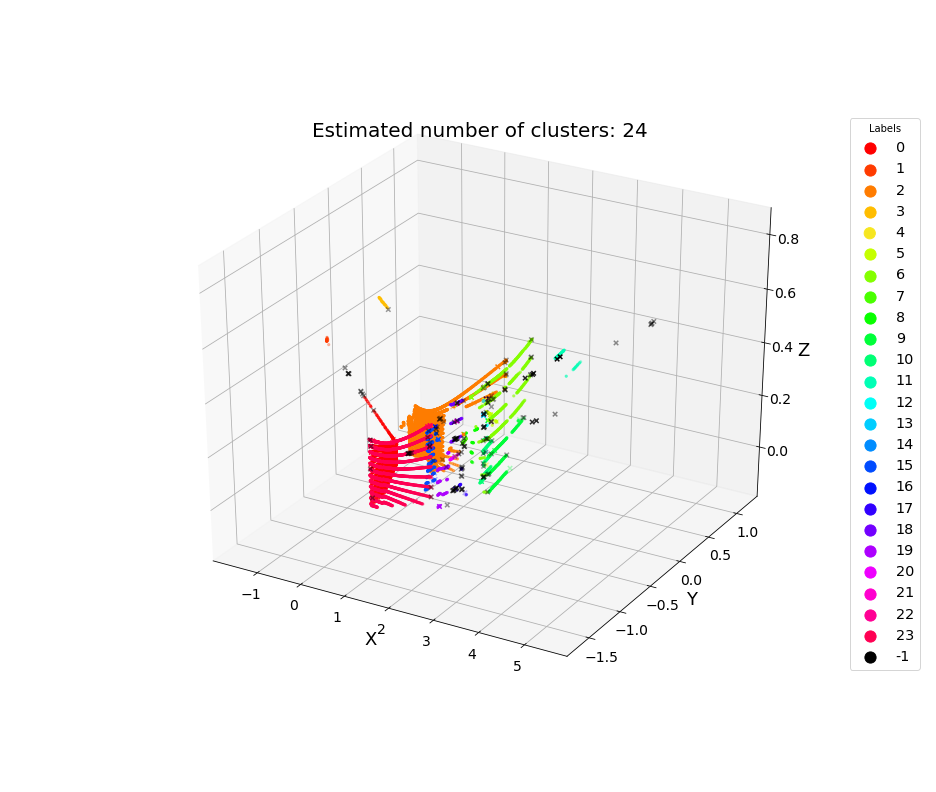

Estimated number of clusters: 24
Estimated number of noise points: 155


In [50]:
plot_3d_cluster_results(cluster_data, clustering_dbscan_eucl)

In [51]:
#  DistanceMetric.get_metric('mahalanobis', V=np.cov(cluster_data))
metric = DistanceMetric.get_metric('mahalanobis', V=np.cov(cluster_data, rowvar=False))

clustering_dbscan_mahal = DBSCAN(eps=0.9, min_samples=10,  metric='mahalanobis', metric_params={'V': np.cov(cluster_data, rowvar=False)}, 
                          algorithm='brute', leaf_size=30, n_jobs=-1).fit(cluster_data)

In [52]:
_,_ = return_cluster_and_noise_points(clustering_dbscan_mahal)


Estimated number of clusters: 9
Estimated number of noise points: 61


<IPython.core.display.Javascript object>


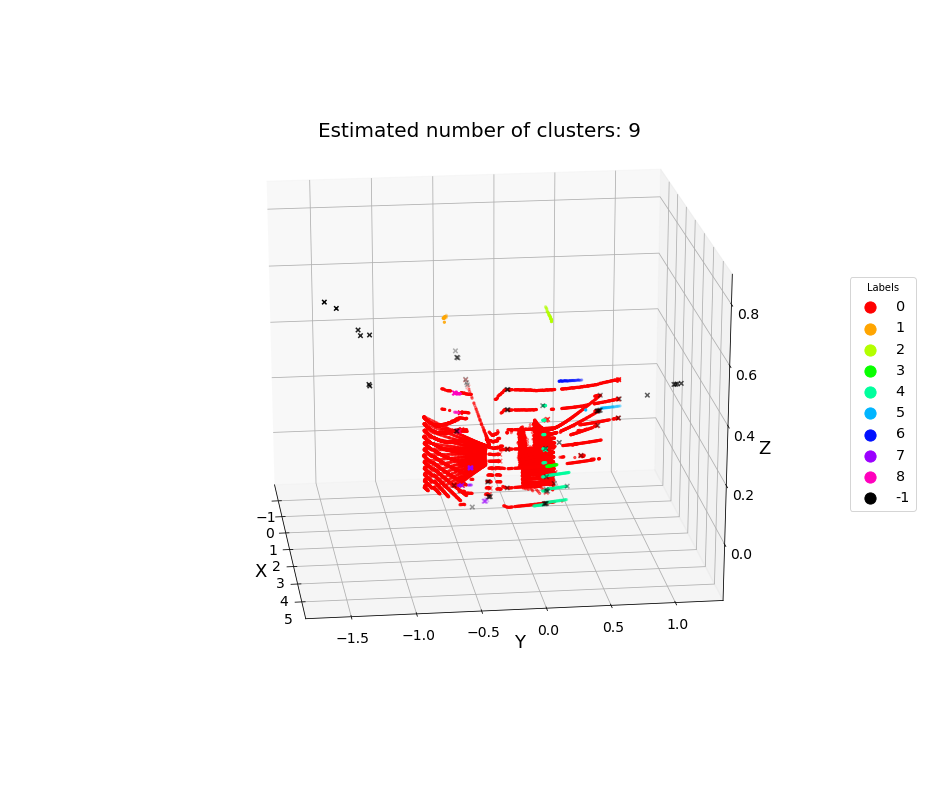

Estimated number of clusters: 9
Estimated number of noise points: 61


In [53]:
plot_3d_cluster_results(cluster_data, clustering_dbscan_mahal)

### 2) OPTICS

In [54]:
from crowd_tracker_lidar3d.optics import OPTICS

In [55]:
clustering_optics = OPTICS(min_samples=100).fit(cluster_data)

In [56]:
_,_ = return_cluster_and_noise_points(clustering_optics)

Estimated number of clusters: 7
Estimated number of noise points: 5350


<IPython.core.display.Javascript object>


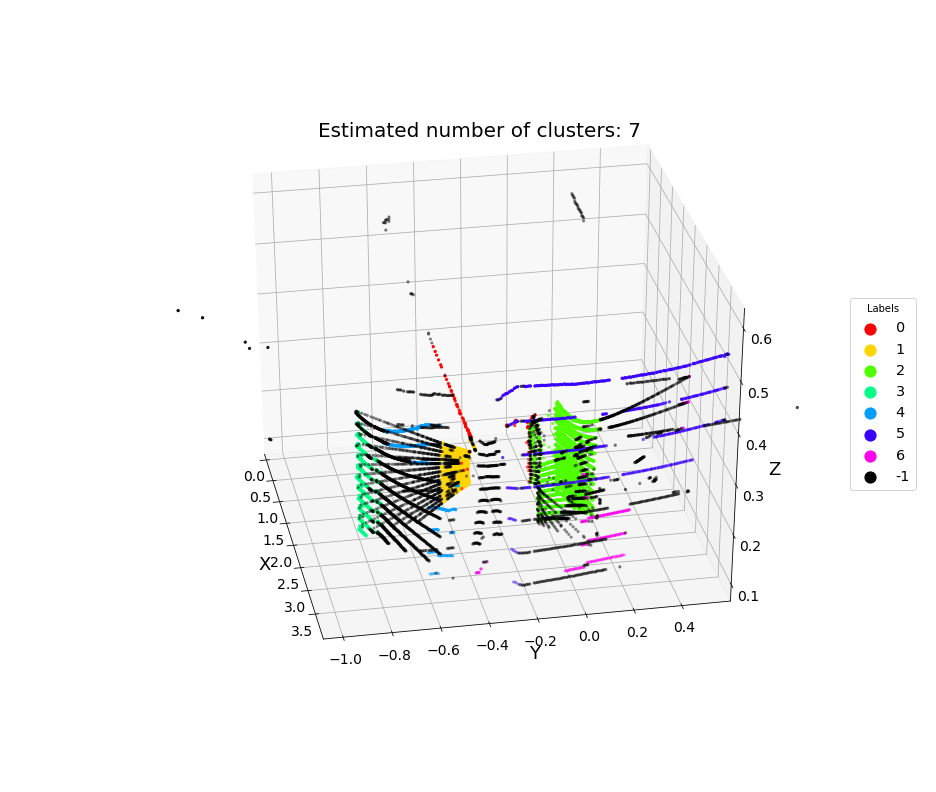

Estimated number of clusters: 7
Estimated number of noise points: 5350


In [50]:
cluster_model = clustering_optics
fig = plt.figure(figsize=[13, 11])
ax = fig.add_subplot(111, projection='3d')
labels = cluster_model.labels_
unique_labels = set(labels)
colors = [plt.cm.hsv(each)  for each in np.linspace(0, 1, len(unique_labels))]
# core_samples_mask = np.zeros_like(labels, dtype=bool)
# core_samples_mask[cluster_model.core_sample_indices_] = True
for k, col in zip(unique_labels, colors):  
    if k == -1:    # Black used for noise.    
        col = [0, 0, 0, 1]  
    class_member_mask = (labels == k) 

    xyz = cluster_data[class_member_mask]  
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=col, marker=".", label=k)

#     xyz_outlier = cluster_data[class_member_mask & ~core_samples_mask]
#     ax.scatter(xyz_outlier[:, 0], xyz_outlier[:, 1], xyz_outlier[:, 2], c=col, marker="x")

ax.set_ylabel('Y', fontsize=18)
ax.set_xlabel('X', fontsize=18)
ax.set_zlabel('Z', fontsize=18)
n_clusters_, _ = return_cluster_and_noise_points(cluster_model)

ax.legend(fontsize='x-large', markerscale=5, loc='center left', bbox_to_anchor=(1, 0.5), title="Labels")
plt.title('Estimated number of clusters: %d' % n_clusters_, fontsize=20)
ax.tick_params(labelsize=14)
plt.show()

### 3) Spectral Clustering

In [24]:
from sklearn.cluster import SpectralClustering

In [33]:
# Tune number of clusters
from scipy.spatial.distance import pdist, squareform
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

In [24]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel

In [25]:
cluster_data.shape

(15820, 4)

In [26]:
similarity_mat_eucl = pairwise_distances(cluster_data)

In [27]:
similarity_mat_eucl.shape

(15820, 15820)

In [29]:
# TODO evaluate on gamma value (now default taken)
similarity_mat_rbf = rbf_kernel(cluster_data)

In [ ]:
from scipy.sparse import csgraph
from numpy import linalg as LA

L = csgraph.laplacian(similarity_mat_eucl, normed=True)
eigenvalues, eigenvectors = LA.eig(L)

In [34]:
import scipy
from scipy.sparse import csgraph
# from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors


In [ ]:
affinity_matrix = getAffinityMatrix(cluster_data, k = 4)

In [ ]:
affinity_matrix = getAffinityMatrix(X, k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {}'.format(str(k)))

In [58]:
spectral_clustering = SpectralClustering(n_clusters=nb_clusters, assign_labels="discretize", random_state=0).fit(clster_data)

plot_3d_cluster_results(cluster_data, spectral_clustering)

NameError: name 'nb_clusters' is not defined

## Preprocessing - Testing
Testing a ground plane segmentation approach taken from [here](https://towardsdatascience.com/point-cloud-data-simple-approach-f3855fdc08f5)

In [ ]:
dataset.shape

In [ ]:
dataset[:, 2].min()

In [ ]:
def frange(start, stop, step):  
    i = start  
    while i < stop:    
        yield i    
        i += step

dataset = start_transformed[['x', 'y','z']].copy().to_numpy()

#ground points grid filter
n = 100 #grid step
dataset_Z_filtered = dataset[[0]]
print(dataset_Z_filtered)

#setting height filtered from ground
zfiltered = (dataset[:, 2].max() - dataset[:, 2].min())/10 
print('zfiltered = ', zfiltered)

xstep = (dataset[:, 0].max() - dataset[:, 0].min())/n
ystep = (dataset[:, 1].max() - dataset[:, 1].min())/n

for x in frange (dataset[:, 0].min(), dataset[:, 0].max(), xstep):  
    for y in frange (dataset[:, 1].min(), dataset[:, 1].max(), ystep):    
        datasetfiltered = dataset[(dataset[:,0] > x)
                                 &(dataset[:, 0] < x+xstep)
                                 &(dataset[:, 1] > y)
                                 &(dataset[:, 1] < y+ystep)]    
        if datasetfiltered.shape[0] > 0:      
            datasetfiltered = datasetfiltered[datasetfiltered[:, 2]
                                >(datasetfiltered[:, 2].min()+ zfiltered)]      
            if datasetfiltered.shape[0] > 0:        
                dataset_Z_filtered = np.concatenate((dataset_Z_filtered, datasetfiltered))

print('dataset_Z_filtered shape', dataset_Z_filtered.shape)

In [ ]:
import pandas as pd
df_filter = pd.DataFrame(dataset_Z_filtered, columns=['x', 'y', 'z'])

### 3D Plot using matplotlib

In [ ]:
%matplotlib notebook

In [ ]:
plot_pointcloud3d(start)

### 3D Plot using pptk
See documentation [here](https://heremaps.github.io/pptk/index.html). 
Example screenshot of interactive 3D visualzation:
<img src="files/pcl_1585676368204491882.png">

In [ ]:
import pptk

In [ ]:
v = pptk.viewer(start[['x', 'y', 'z']]) 
v.attributes(start['intensity'])
v.set(point_size=0.001)

In [ ]:
v.capture('/home/brudermueller/Downloads/pcl_{}.png'.format(str(timesteps[0])))

In [ ]:
len(timesteps)

In [ ]:
# take only every 40th timestep
subsample = timesteps[::40]

In [ ]:
len(subsample)

In [ ]:
pcl = data[data.rosbagTimestamp == timesteps[150]].reset_index()
pcl = df_apply_rot(pcl)
pcl = remove_ground_points(pcl, -0.38)
pcl.head()
pcl = pcl[(pcl.x.between(2.9, 3.5)) & (pcl.y.between(-1, 2))]
v = pptk.viewer(pcl[['x', 'y', 'z']]) 
v.attributes(pcl['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=7)   

In [ ]:
# save screenshot of lidar 3D plot for each timestep 
import time
for i,t in enumerate(timesteps[15:-1]): 
    pcl = data[data.rosbagTimestamp == t].reset_index()
    pcl = df_apply_rot(pcl)
    pcl = remove_ground_points(pcl, -0.38)
    pcl = pcl[(pcl.x.between(2.9, 3.5)) & (pcl.y.between(-1, 2))]
    v = pptk.viewer(pcl[['x', 'y', 'z']]) 
    v.attributes(pcl['intensity'])
    v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=8)    
    time.sleep(2)
    v.capture('/home/brudermueller/Downloads/{}m_pcl_groundtruth_{}.png'.format(str(walking_dist),i))
    time.sleep(2)
    v.close()

In [ ]:
v = pptk.viewer(start_ground[['x', 'y', 'z']]) 
v.attributes(start_ground['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)

In [ ]:
v = pptk.viewer(start[['x', 'y', 'z']]) 
v.attributes(start['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)